In [1]:
import numpy as np
import pandas as pd

In [2]:
import subprocess as sp

In [3]:
# clustering imports
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import AgglomerativeClustering

In [4]:
# statistical analysis imports
from scipy.stats import mannwhitneyu
from scipy.stats import spearmanr

In [5]:
# plotting imports
from matplotlib import pyplot as plt
import textwrap
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

In [6]:
def runR(script, output = True):
    result = sp.run(['/usr/local/bin/Rscript', script], capture_output=True)

    if result.stderr:
        print("Error: ")
        print(result.stderr)
    
    if output: 
        print("Result: ")
        print(result.stdout)
        
    return

In [12]:
custom_palette = 'RdBu_r'

## Calculation of TF and pathway activities

In [8]:
# Calculation of TF and pathway activity of drug signatures
# It takes time
runR('../code/progeny_dorothea_l1000_l10000.R')

In [9]:
# Calculation of TF and pathway activity of virus signatures
runR('../code/virus_signatures_dorothea.R')

In [10]:
runR('../code/virus_signatures_progeny_bioconductor.R')

# Virus signatures

In [8]:
samples = ['GSE147507.S5_A549_SARS.CoV.2','GSE147507.S7_Calu3_SARS.CoV.2','GSE148729_Calu3_SARS.CoV.2_24H']

### PROGENy

In [6]:
virus_pathways = pd.read_csv('../results/microarray_and_rnaseq_progeny_z_bioconductor.csv', index_col=0)

In [9]:
virus_pathways = virus_pathways[samples]
virus_pathways.columns = ['GSE147507 A549', 'GSE147507 Calu-3', 'GSE148729 Calu-3']

In [10]:
custom_palette_vh = sns.color_palette("RdBu_r", 120)[:48] + sns.color_palette("RdBu_r", 120)[72:]

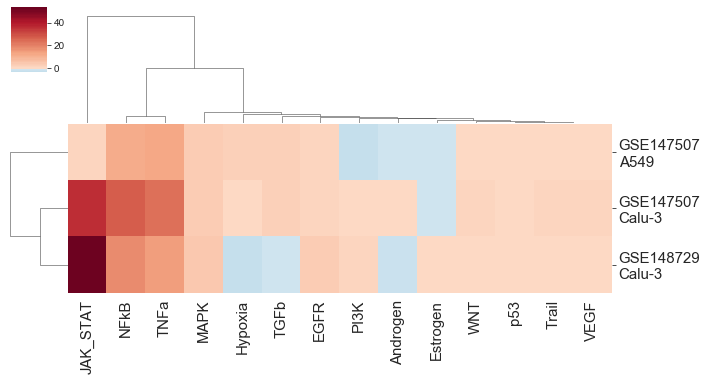

In [11]:
g = sns.clustermap(virus_pathways.T,cmap=custom_palette_vh, figsize=(10,5), dendrogram_ratio=(.1, .4), center = 0)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 15)
g.ax_heatmap.set_yticklabels((textwrap.fill(y.get_text(), 9) for y in g.ax_heatmap.get_ymajorticklabels()), 
                             fontsize = 15)
plt.show()

### DoRothEA

In [13]:
virus_tf_activities = pd.read_csv('../results/microarray_and_rnaseq_dorothea_ABC.csv', sep=',', header=0, index_col=0)

In [14]:
virus_tf_activities = virus_tf_activities.loc[samples]
virus_tf_activities.index = ['GSE147507 A549', 'GSE147507 Calu-3', 'GSE148729 Calu-3']

In [15]:
changed_tfs = virus_tf_activities.columns[virus_tf_activities.abs().mean()>4]

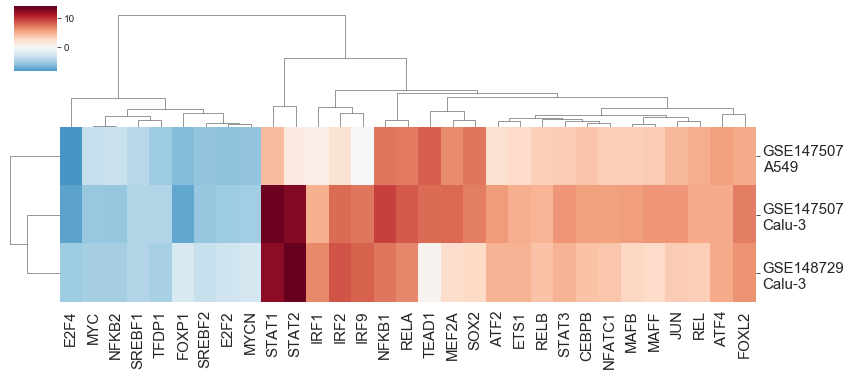

In [16]:
g = sns.clustermap(virus_tf_activities[changed_tfs],cmap=custom_palette,xticklabels=True, figsize=(12,5), 
                  dendrogram_ratio=(.07, .4), center = 0)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 15)
g.ax_heatmap.set_yticklabels((textwrap.fill(y.get_text(), 9) for y in g.ax_heatmap.get_ymajorticklabels()), 
                             fontsize = 15)
plt.show()

# Drug signatures

In [17]:
chembl_drugs = pd.read_csv('../results/drugs/chembl_drugs.csv', sep=',', header=0, index_col=0)

In [18]:
effective_dugs = chembl_drugs['0'].values

### PROGENy

In [19]:
drug_pathways = pd.read_csv('../results/drug_signatures/signatures_bing_gene_progeny_z.csv', sep=',', header=0, 
                     index_col=0)

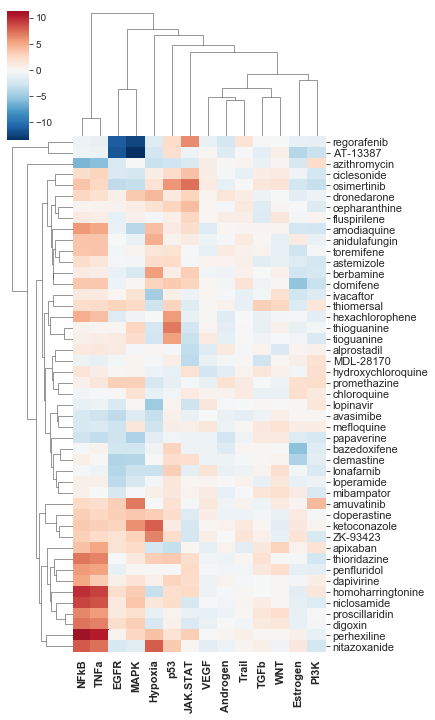

In [20]:
g = sns.clustermap(drug_pathways[effective_dugs].T, cmap=custom_palette, yticklabels=True, figsize=(6, 10), center = 0)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 11, fontweight = 'bold')
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 11)
plt.show()

### DoRothEA

In [21]:
drug_tf_activities = pd.read_csv('../results/drug_signatures/signatures_bing_gene_dorothea.csv', sep=',', header=0,
                     index_col=0)

In [22]:
clustering = linkage(drug_tf_activities.loc[effective_dugs],method='average')

###### Setting colors of clusters

In [23]:
pal = sns.color_palette('RdBu_r', 7) #custom_palette_notcmap
cluster_colors = pal.as_hex()

In [24]:
cluster_dict = {}
i=0
for color in cluster_colors:
    cluster_dict[i] = color
    i=i+1

##### Clustering drugs based on TF activities

In [25]:
model = AgglomerativeClustering(linkage='average', n_clusters=7)
model.fit(drug_tf_activities.loc[effective_dugs])
model.fit_predict(drug_tf_activities.loc[effective_dugs])
clusters = pd.Series(model.fit_predict(drug_tf_activities.loc[effective_dugs]),index=effective_dugs)

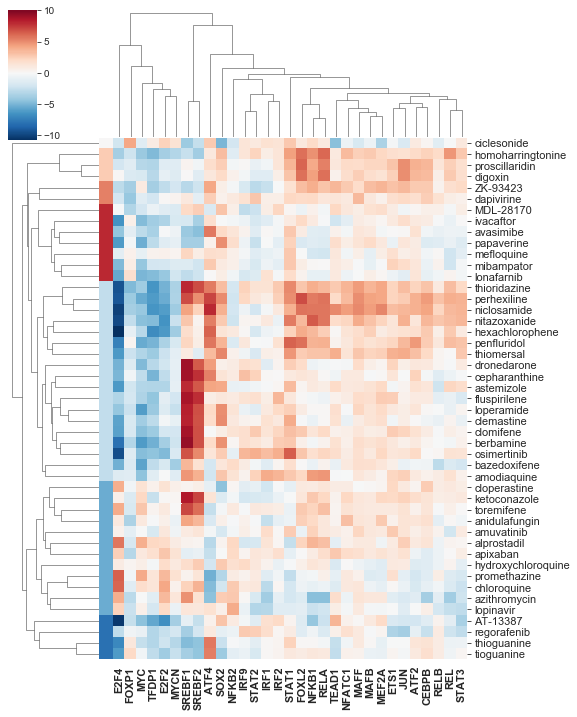

In [26]:
g = sns.clustermap(drug_tf_activities.loc[effective_dugs, changed_tfs], cmap=custom_palette, xticklabels=True,
                   yticklabels=True, row_colors=clusters.map(cluster_dict), figsize=(8,10), 
                   row_linkage=clustering, vmax=10, center=0)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 11, fontweight = 'bold')
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 11)
plt.show()

# Relationship between average TF activities induced by drug treatment and SARS-CoV-2 infection in 5 different drug clusters

In [27]:
virus_tf_activities = pd.read_csv('../results/microarray_and_rnaseq_dorothea_ABC.csv', sep=',', header=0, index_col=0)

drug_tf_activities = pd.read_csv('../results/drug_signatures/signatures_bing_gene_dorothea.csv', sep=',', header=0,
                     index_col=0)

In [28]:
virus_tf_activities = virus_tf_activities.loc[samples]
virus_tf_activities.index = ['GSE147507 A549', 'GSE147507 Calu-3', 'GSE148729 Calu-3']

In [29]:
textpos_dict = {}
for c in np.unique(clusters):
    tfs = list(set(drug_tf_activities.columns) & set(virus_tf_activities.columns))
    means = pd.DataFrame(columns=['tf', 'x_mean', 'y_mean'])
    drugs = clusters.index[clusters==c]
    for tf in tfs:
        ser = pd.Series([tf,drug_tf_activities.loc[drugs,tf].mean(), virus_tf_activities[tf].mean()],index=means.columns)
        means = means.append(ser,ignore_index=True)
    means = means.set_index('tf')
    x_means = means['x_mean']
    y_means = means['y_mean']
    means = means[((means['x_mean'] >  x_means.max()*0.6) | (means['x_mean'] <  x_means.min()*0.6)) & 
                  ((means['y_mean'] >  y_means.max()*0.6) | (means['y_mean'] <  y_means.min()*0.6)) |
                 ((means['x_mean'] >  x_means.max()*0.8) | (means['x_mean'] <  x_means.min()*0.8) | 
                 (means['y_mean'] >  y_means.max()*0.8) | (means['y_mean'] <  y_means.min()*0.8))]
    textpos_dict[c] = means

In [30]:
def plot_txt(c):
    
    
    textpos_dict[c].sort_values('y_mean')
    for tf in tfs:
        if tf in textpos_dict[c].index:
            if c == 1: 
                va = 'bottom' if tf in ['SREBF1', 'STAT1'] else 'top'
                ha = 'right' if tf in ['E2F2', 'E2F4'] else 'left'
            elif c == 3: 
                ha = 'right' if tf in ['FOXO3', 'FOXP1', 'SOX2'] else 'left'
                va = 'bottom' if tf in ['TCF12'] else 'top'
            elif c == 2: 
                ha = 'right' if tf in ['STAT2', 'MYC'] else 'left'
                va = 'bottom' if tf in ['SREBF1', 'STAT2'] else 'top'
                ha = 'center' if tf in ['SREBF2', 'SREBF1', 'STAT1'] else ha
            elif c == 6:
                ha = 'center' if tf in [ 'MYC', 'ZNF263', 'PRDM14', 'POU2F1','STAT1'] else 'left'
                va = 'bottom' if tf in ['PRDM14', 'MYC', 'STAT2', 'ZNF263'] else 'top' #, 'POU2F1'
                va = 'center' if tf == 'POU2F1' else va
            elif c == 5:
                ha = 'right' if tf in ['KLF4', 'KLF9'] else 'left'
                va = 'bottom' if tf in ['KLF4', 'TFAP2A', 'MAX'] else 'top'     
            elif c == 0:
                ha = 'right' if tf in ['SSRP1', 'KMT2A', 'STAT1', 'ARID2', 'ATF4'] else 'left'
                va = 'bottom' if tf in ['KMT2A', 'ATF4', 'E2F4', 'STAT1'] else 'top'   
            elif c == 4:
                ha = 'right' if tf in ['FOXL2', 'RELA', 'NFKB1', 'ARID2', 'STAT2'] else 'left'
                va = 'bottom' if tf in ['MYC', 'STAT1', 'NFKB1', 'STAT2', 'MAZ'] else 'top'   
            else:
                va = 'top'
                ha = 'left'
                
            if tf == 'SREBF1' or tf == 'SREBF2':
                color = 'darkred'
            else:
                color = 'black'
            
            plt.text(textpos_dict[c].loc[tf, 'x_mean'], textpos_dict[c].loc[tf, 'y_mean'],tf, 
                     va = va, ha=ha, fontdict={'family': 'sans-serif','weight': 'bold',
                                               'color': color,'size': 12})
            #i=i+1

In [31]:
def cluster_subplots(c):
    drugs = clusters.index[clusters==c]
    ax = plt.plot(drug_tf_activities.loc[drugs,tfs].mean(), virus_tf_activities[tfs].mean(),
                  color=cluster_dict[c], marker='.', linestyle='',markersize=4)
    plot_txt(c)

In [32]:
def save_cluster_spearman(c):
    drugs = clusters.index[clusters==c]
    spearman = spearmanr(drug_tf_activities.loc[drugs,tfs].mean(), virus_tf_activities[tfs].mean())
    # print(c, cluster_dict[c], end=' ')
    # print(spearmanr(drug_tf_activities.loc[drugs,tfs].mean(), virus_tf_activities[tfs].mean()))
    corr = pd.Series([c, cluster_dict[c], spearman[0], spearman[1]], index=['cluster_number', 'color', 'r', 'p-value'])
    return corr

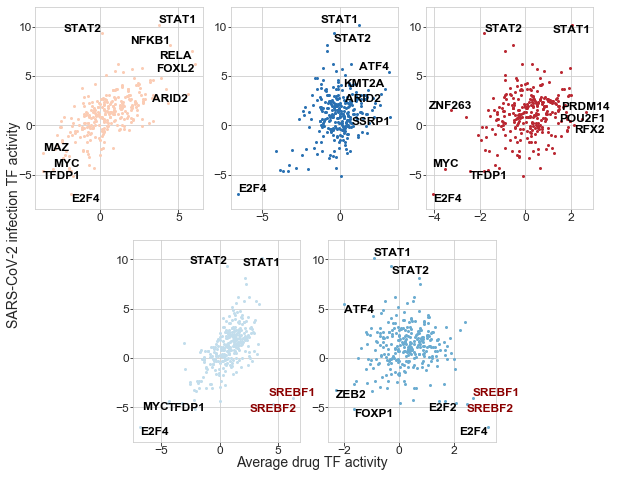

In [33]:
fig = plt.figure(figsize=(10,8))

tfs = list(set(drug_tf_activities.columns) & set(virus_tf_activities.columns))

grid = plt.GridSpec(2, 1, wspace=0.4, hspace=0.15, figure=fig)

gs0 = gridspec.GridSpecFromSubplotSpec(1, 6, subplot_spec=grid[0], wspace=0.4, hspace=0.15)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 6, subplot_spec=grid[1],  wspace=0.4, hspace=0.15)

ax0 = fig.add_subplot(grid[:,:])
ax0.grid(False)
ax0.set_frame_on(False)
ax0.set_xticks([])
ax0.set_yticks([])

ax1 = fig.add_subplot(gs0[0, :2])
c= 4
cluster_subplots(c)
c4 = save_cluster_spearman(c)

ax2 = fig.add_subplot(gs0[0, 2:4])
c= 0
ax2 = cluster_subplots(c)
c0 = save_cluster_spearman(c)

ax3 = fig.add_subplot(gs0[0, 4:])
c= 6
ax3 = cluster_subplots(c)
c6 = save_cluster_spearman(c)


ax4 = fig.add_subplot(gs1[0, 1:3])
c= 2
ax4 = cluster_subplots(c)
c2 = save_cluster_spearman(c)

ax5 = fig.add_subplot(gs1[0, 3:5])
c= 1
ax5 = cluster_subplots(c)
c1 = save_cluster_spearman(c)

correlations = pd.DataFrame(columns = ['cluster_number', 'color', 'r', 'p-value'])
correlations = correlations.append([c4, c0, c6, c2, c1])

ax0.set_xlabel('Average drug TF activity ', labelpad=14, fontsize =14)
ax0.set_ylabel('SARS-CoV-2 infection TF activity', labelpad = 14, fontsize = 14)


for ax in fig.get_axes():
    ax.tick_params(labelsize=12, bottom=True, left=True, pad=0)
    ax.set_ylim([-8.5,12])

plt.show()

In [34]:
correlations.style.applymap(lambda val: 'background-color: %s' % val)

,cluster_number,color,r,p-value
0,4,#fbccb4,0.642379,0.000000
1,0,#2a71b2,0.147632,0.012284
2,6,#ba2832,0.184021,0.001744
3,2,#c2ddec,0.580293,0.000000
4,1,#6bacd1,0.041385,0.484964
